In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LinearRegression
import numpy as np

/var/folders/52/_4ng7h2n79nc2919vnyqx_gr0000gn/T/ipykernel_5845/3445294467.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=top5_ggr_gdp_table, x='Average GGR as % of GDP', y='State', palette='viridis')


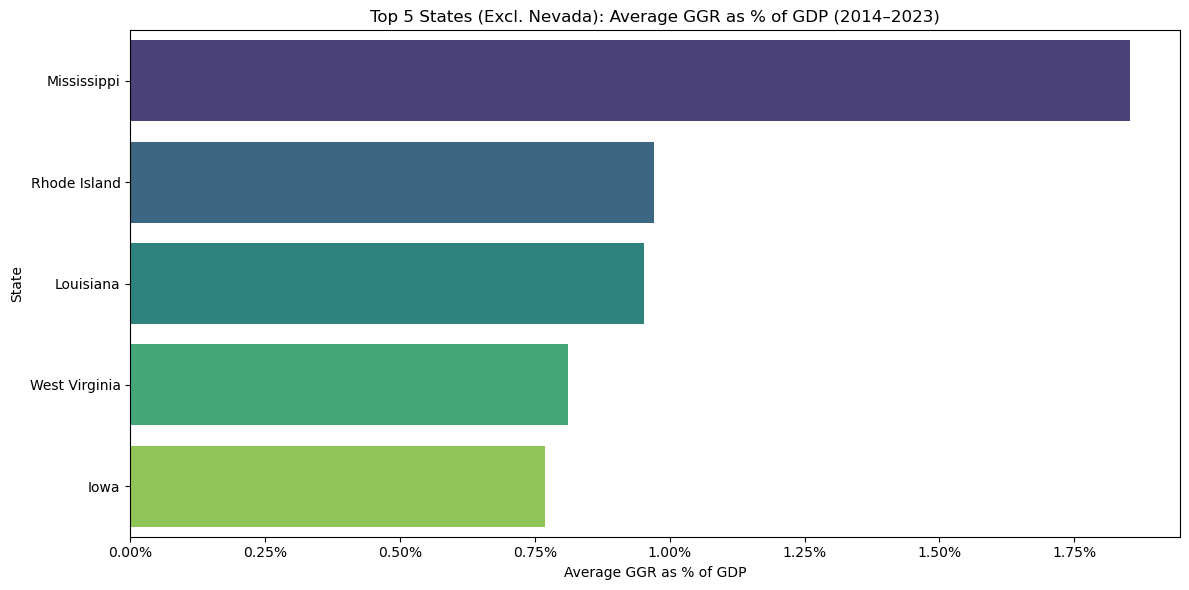

In [11]:
#Top 5 States - GGR as % of GDP

file_path = "/Users/kieransantos/Downloads/Casino Revenue_Tax Revenue_GDP by state (5).xlsx"
excel_data = pd.ExcelFile(file_path)


df_main = excel_data.parse('2014-2023')
df_gdp = excel_data.parse('gdp')

df_merged = pd.merge(df_main, df_gdp, on=['State', 'Year'], how='left')
df_merged['GGR_to_GDP'] = df_merged['Gross Gambling Revenue'] / df_merged['GDP']

df_no_nevada = df_merged[df_merged['State'] != 'Nevada']
avg_ggr_gdp = df_no_nevada.groupby('State')['GGR_to_GDP'].mean().sort_values(ascending=False).head(5)
top5_ggr_gdp_table = avg_ggr_gdp.reset_index()
top5_ggr_gdp_table.columns = ['State', 'Average GGR as % of GDP']

plt.figure(figsize=(12, 6))
bar = sns.barplot(data=top5_ggr_gdp_table, x='Average GGR as % of GDP', y='State', palette='viridis')
bar.set_title("Top 5 States (Excl. Nevada): Average GGR as % of GDP (2014–2023)")
bar.set_xlabel("Average GGR as % of GDP")
bar.xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.tight_layout()
plt.show()


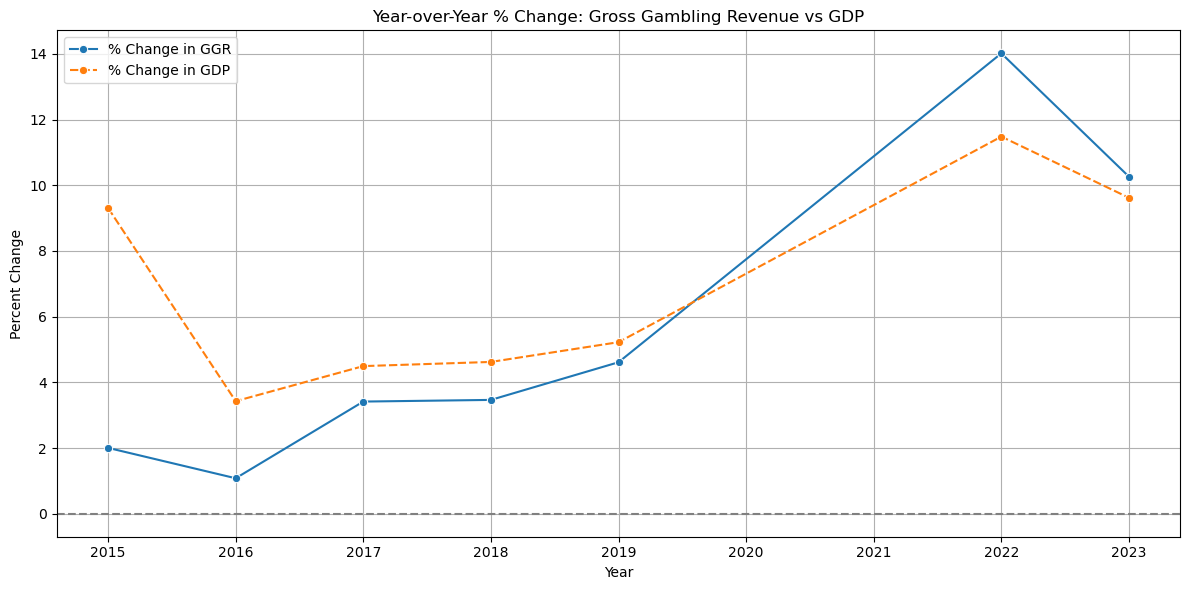

In [15]:
#Year-over-Year % Change: Gross Gambling Revenue vs GDP

df_5 = excel_data.parse('2014-2023')
df_gdp = excel_data.parse('gdp')

df_merged = pd.merge(df_5, df_gdp, on=['State', 'Year'], how='left')

df_merged['GGR_to_GDP'] = df_merged['Gross Gambling Revenue'] / df_merged['GDP']

yearly_totals = df_merged.dropna(subset=['GDP']).groupby('Year')[['Gross Gambling Revenue', 'GDP']].sum()

yearly_pct_change = yearly_totals.pct_change().dropna() * 100  

yearly_pct_change.columns = ['% Change in GGR', '% Change in GDP']

yearly_pct_change_excl_2020_2021 = yearly_pct_change[~yearly_pct_change.index.isin([2020, 2021])]

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_pct_change_excl_2020_2021, marker='o')
plt.title("Year-over-Year % Change: Gross Gambling Revenue vs GDP")
plt.ylabel("Percent Change")
plt.xlabel("Year")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/52/_4ng7h2n79nc2919vnyqx_gr0000gn/T/ipykernel_5845/367279214.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'${int(y/1e9)}B' for y in plt.gca().get_yticks()])


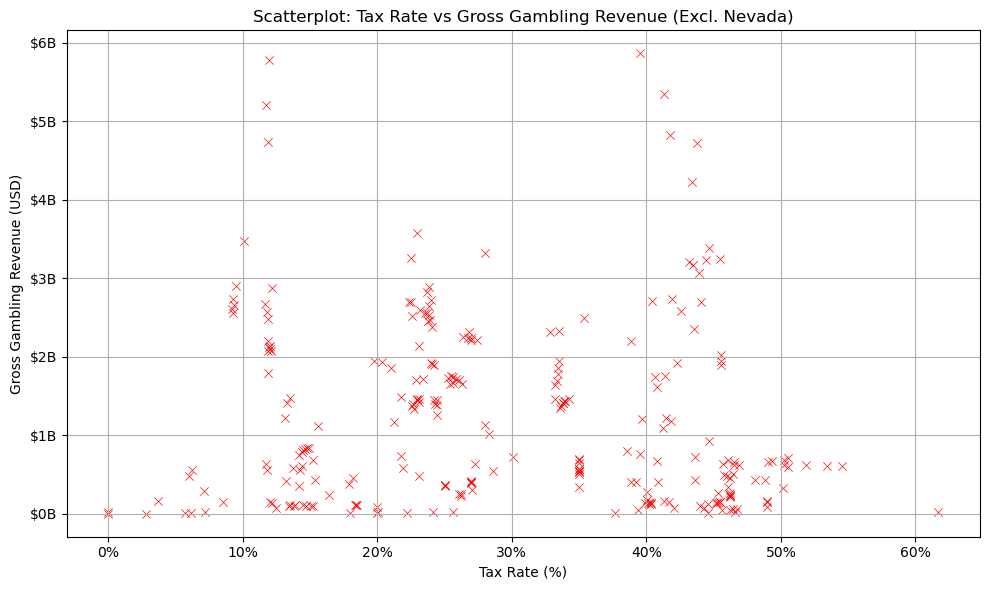

In [17]:
#Scatterplot: Tax Rate vs Gross Gambling Revenue (Excl. Nevada)

df_scatter_no_nevada = df_merged[df_merged['State'] != 'Nevada']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scatter_no_nevada, x='Tax Rate', y='Gross Gambling Revenue', color='red', marker='x')

plt.title("Scatterplot: Tax Rate vs Gross Gambling Revenue (Excl. Nevada)")
plt.xlabel("Tax Rate (%)")
plt.ylabel("Gross Gambling Revenue (USD)")

plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.gca().set_yticklabels([f'${int(y/1e9)}B' for y in plt.gca().get_yticks()])

plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/52/_4ng7h2n79nc2919vnyqx_gr0000gn/T/ipykernel_5845/102124001.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'${int(y/1e9)}B' for y in plt.gca().get_yticks()])


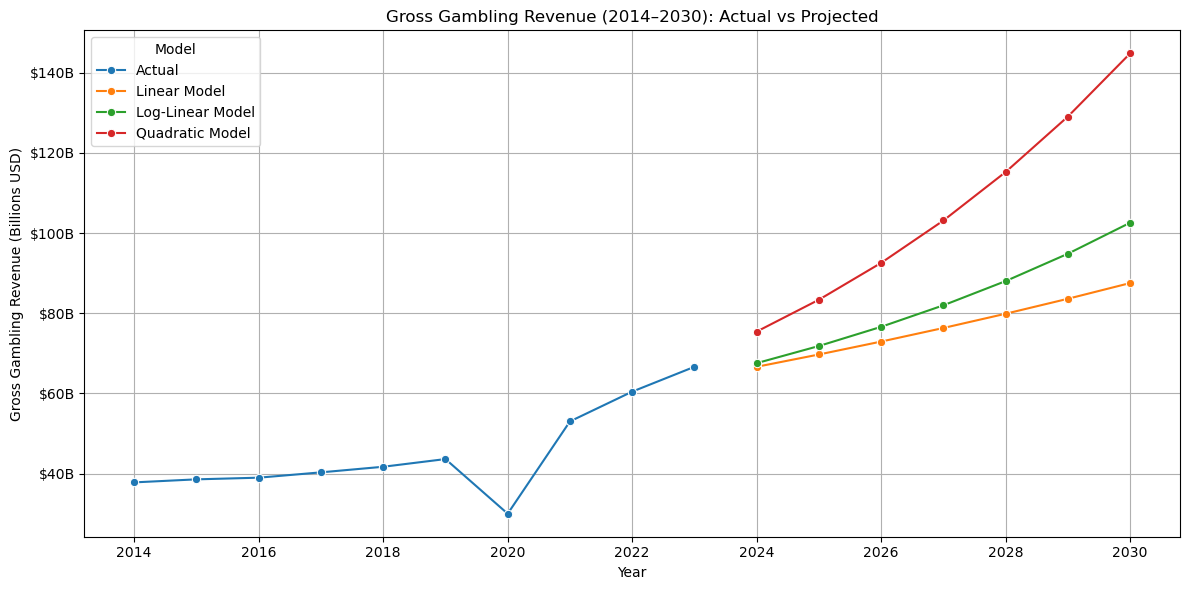

In [25]:
#Gross Gambling Revenue (2014–2030): Actual vs Projected by Model



df_merged = pd.merge(df_5, df_gdp, on=['State', 'Year'], how='left')
df_merged['GGR_to_GDP'] = df_merged['Gross Gambling Revenue'] / df_merged['GDP']
yearly_totals = df_merged.dropna(subset=['GDP']).groupby('Year')[['Gross Gambling Revenue', 'GDP']].sum()
X_gdp = yearly_totals['GDP'].values.reshape(-1, 1)
y_ggr = yearly_totals['Gross Gambling Revenue'].values


model = LinearRegression().fit(X_gdp, y_ggr)

y_log_ggr = np.log(y_ggr)
log_linear_model = LinearRegression().fit(X_gdp, y_log_ggr)

X_quad = np.column_stack((X_gdp, X_gdp**2))
quad_model = LinearRegression().fit(X_quad, y_ggr)

gdp_2023 = yearly_totals.loc[2023, 'GDP']
future_years = list(range(2024, 2031))
gdp_future = [gdp_2023 * (1.05 ** (year - 2023)) for year in future_years]
gdp_future_array = np.array(gdp_future).reshape(-1, 1)

ggr_linear = model.predict(gdp_future_array)
ggr_log_linear = np.exp(log_linear_model.predict(gdp_future_array))
gdp_future_quad = np.column_stack((gdp_future_array, gdp_future_array**2))
ggr_quadratic = quad_model.predict(gdp_future_quad)

historical_data = yearly_totals[['Gross Gambling Revenue']].reset_index()
historical_data.columns = ['Year', 'GGR']
historical_data['Model'] = 'Actual'

projection_data = pd.DataFrame({
    'Year': future_years * 3,
    'GGR': np.concatenate([ggr_linear, ggr_log_linear, ggr_quadratic]),
    'Model': ['Linear Model'] * len(future_years) +
             ['Log-Linear Model'] * len(future_years) +
             ['Quadratic Model'] * len(future_years)
})

full_plot_data = pd.concat([historical_data, projection_data], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=full_plot_data, x='Year', y='GGR', hue='Model', marker='o')
plt.title("Gross Gambling Revenue (2014–2030): Actual vs Projected")
plt.ylabel("Gross Gambling Revenue (Billions USD)")
plt.xlabel("Year")

plt.gca().set_yticklabels([f'${int(y/1e9)}B' for y in plt.gca().get_yticks()])

plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/52/_4ng7h2n79nc2919vnyqx_gr0000gn/T/ipykernel_5845/438101819.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${int(y/1e9)}B' for y in ax.get_yticks()])
/var/folders/52/_4ng7h2n79nc2919vnyqx_gr0000gn/T/ipykernel_5845/438101819.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${int(y/1e9)}B' for y in ax.get_yticks()])
/var/folders/52/_4ng7h2n79nc2919vnyqx_gr0000gn/T/ipykernel_5845/438101819.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'${int(y/1e9)}B' for y in ax.get_yticks()])
/var/folders/52/_4ng7h2n79nc2919vnyqx_gr0000gn/T/ipykernel_5845/438101819.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after 

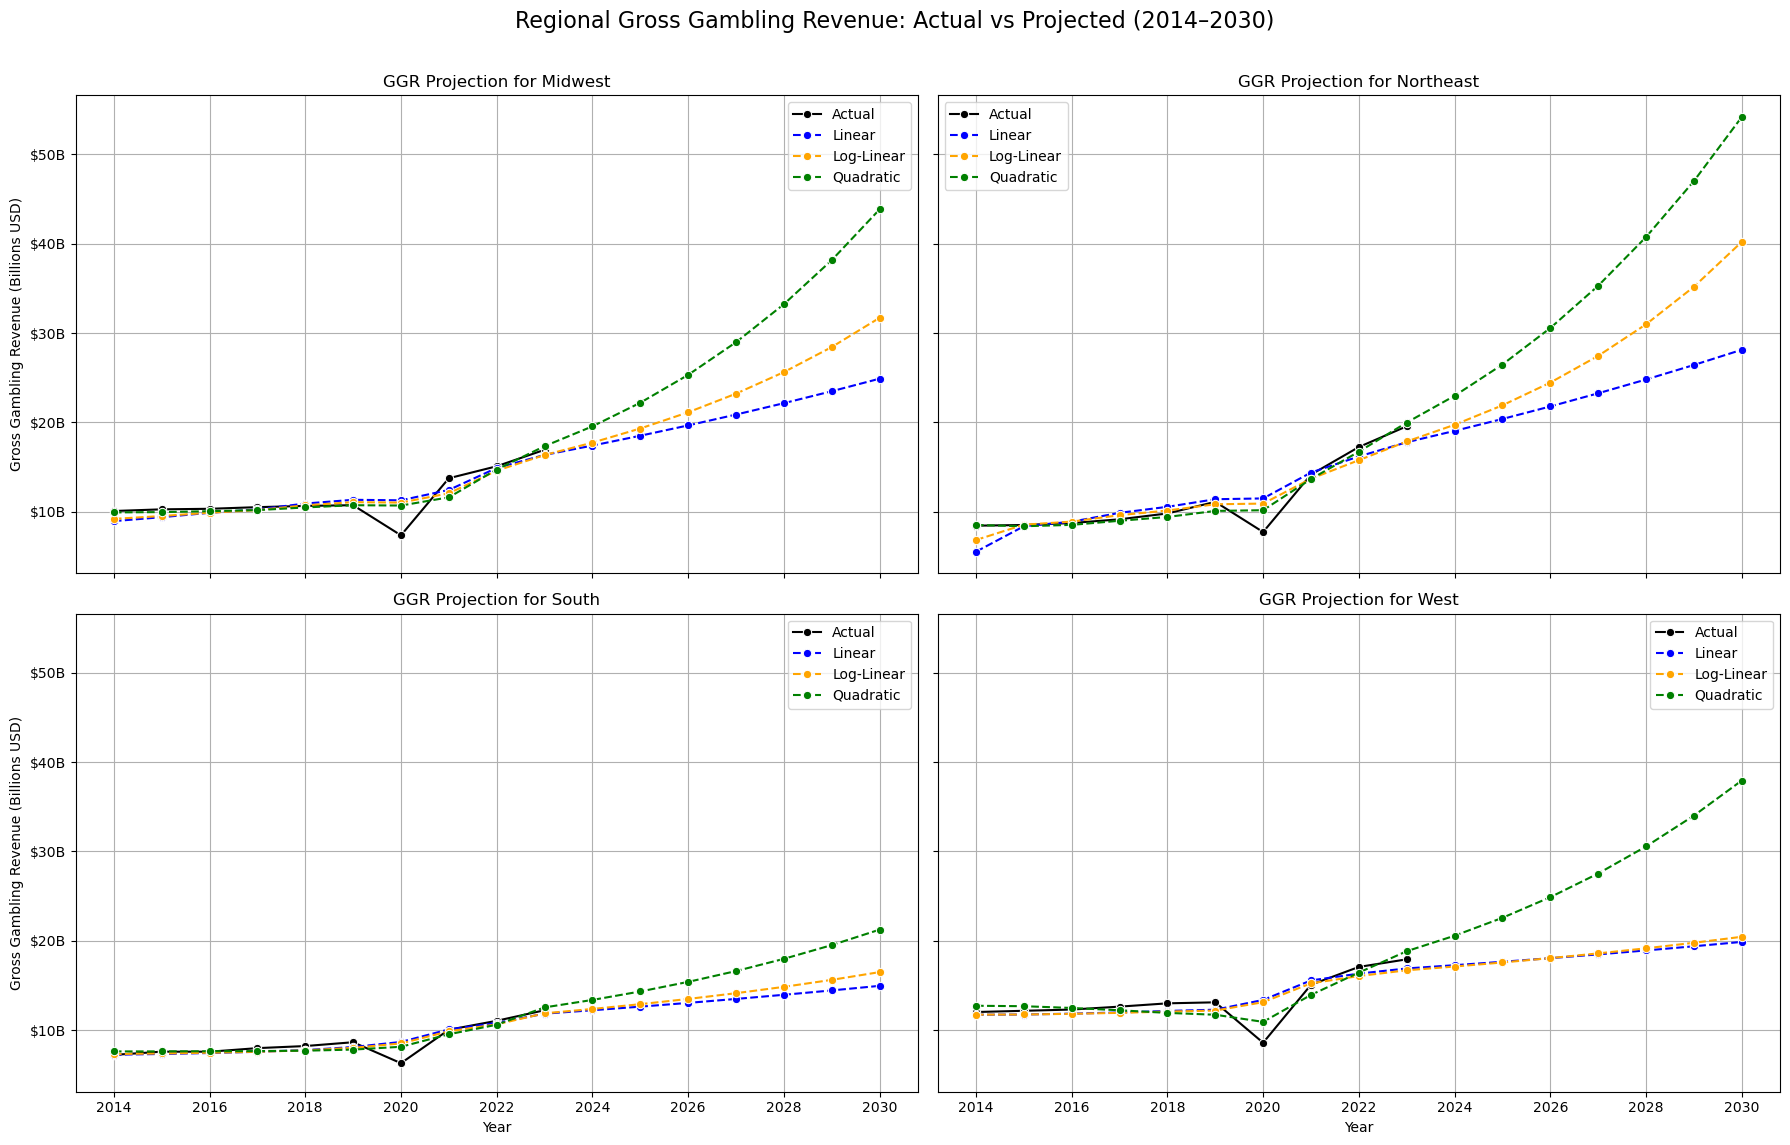

In [31]:
#Regional Gross Gambling Revenue: Actual vs Projected (2014–2030)

file_path = "/Users/kieransantos/Downloads/Casino Revenue_Tax Revenue_GDP by state (6).xlsx"  
excel_data = pd.ExcelFile(file_path)

df_main = excel_data.parse('2014-2023')
df_gdp = excel_data.parse('gdp')

df_merged = pd.merge(df_main, df_gdp, on=['State', 'Year'], how='left')
df_merged['GGR_to_GDP'] = df_merged['Gross Gambling Revenue'] / df_merged['GDP']



if 'Region' not in df_merged.columns:
    df_merged['Region'] = 'Unknown'

region_year_totals = df_merged.groupby(['Region', 'Year'])[['Gross Gambling Revenue', 'GDP']].sum().reset_index()

region_plots = {}
future_years = list(range(2024, 2031))

for region in region_year_totals['Region'].unique():
    df_region = region_year_totals[region_year_totals['Region'] == region].copy()
    X = df_region['GDP'].values.reshape(-1, 1)
    y = df_region['Gross Gambling Revenue'].values

    linear_model = LinearRegression().fit(X, y)
    linear_pred = linear_model.predict(X)

    log_y = np.log(y)
    log_linear_model = LinearRegression().fit(X, log_y)
    log_linear_pred = np.exp(log_linear_model.predict(X))

    X_quad = np.column_stack((X, X**2))
    quad_model = LinearRegression().fit(X_quad, y)
    quad_pred = quad_model.predict(X_quad)

    last_gdp = df_region[df_region['Year'] == 2023]['GDP'].values[0]
    gdp_proj = [last_gdp * (1.05 ** (i + 1)) for i in range(len(future_years))]
    X_proj = np.array(gdp_proj).reshape(-1, 1)
    X_proj_quad = np.column_stack((X_proj, X_proj**2))

    proj_df = pd.DataFrame({
        'Year': future_years,
        'Linear': linear_model.predict(X_proj),
        'Log-Linear': np.exp(log_linear_model.predict(X_proj)),
        'Quadratic': quad_model.predict(X_proj_quad)
    })

    actual_df = df_region[['Year']].copy()
    actual_df['Actual'] = y
    actual_df['Linear'] = linear_pred
    actual_df['Log-Linear'] = log_linear_pred
    actual_df['Quadratic'] = quad_pred

    combined_df = pd.concat([actual_df, proj_df], ignore_index=True)
    combined_df['Region'] = region
    region_plots[region] = combined_df

fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (region, data) in enumerate(region_plots.items()):
    ax = axes[i]
    sns.lineplot(data=data, x='Year', y='Actual', ax=ax, label='Actual', color='black', marker='o')
    sns.lineplot(data=data, x='Year', y='Linear', ax=ax, label='Linear', linestyle='--', color='blue', marker='o')
    sns.lineplot(data=data, x='Year', y='Log-Linear', ax=ax, label='Log-Linear', linestyle='--', color='orange', marker='o')
    sns.lineplot(data=data, x='Year', y='Quadratic', ax=ax, label='Quadratic', linestyle='--', color='green', marker='o')
    ax.set_title(f"GGR Projection for {region}")
    ax.set_ylabel("Gross Gambling Revenue (Billions USD)")
    ax.set_xlabel("Year")
    ax.set_yticklabels([f'${int(y/1e9)}B' for y in ax.get_yticks()])
    ax.grid(True)

plt.suptitle("Regional Gross Gambling Revenue: Actual vs Projected (2014–2030)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()